# Plot regional maps with mean current ellipses on top


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import xarray as xr

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import palettable
from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean_blue
from palettable.cmocean.sequential import Gray_12 as ocean_gray

plt.style.use('dark_background')
%matplotlib inline

#plt.rcParams.update({'font.size': 14})

## 1. Load data

### Load location of EEL stations

In [2]:
pathdir = '../data/raw/csv_ctdgrid'

file3 = pathdir+'/'+'EELCTDandLADCP_refpos.csv'
dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.sort_values('Refdist', ascending=True)
sdfloc['Refdist']=sdfloc['Refdist'].apply(int)
sdfloc

,Staname,Refdist,LonSta,LatSta,DepthSta
68,IB23S,0,-20.215,63.317,120
67,IB22S,13,-20.067,63.216,670
66,IB21S,25,-19.916,63.133,1030
65,IB20S,55,-19.551,62.917,1400
64,IB19S,84,-19.668,62.667,1670
...,...,...,...,...,...
4,5G,1277,-6.600,56.733,80
3,4G,1286,-6.450,56.733,115
2,3G,1292,-6.367,56.708,70
1,2G,1298,-6.283,56.683,30


<br><br>
### Load LADCP Current data into a dataframe

In [3]:
file4 = pathdir+'/'+'EEL_LADCP_3Dfield.csv'
dflad = pd.read_csv(file4,sep=',', index_col=None, 
                     header=0)
dflad=dflad.round({'LADCP_U': 3, 'LADCP_V': 3})
dflad['Refdist']=dflad['Refdist'].apply(int)
dflad

,CruiseID,Year,Staname,Refdist,Depth,LADCP_U,LADCP_V
0,d22396,1996,13G,1191,25,-0.227,0.019
1,d22396,1996,13G,1191,35,-0.230,0.044
2,d22396,1996,13G,1191,45,-0.236,0.049
3,d22396,1996,13G,1191,55,-0.251,0.052
4,d22396,1996,13G,1191,65,-0.283,0.066
...,...,...,...,...,...,...,...
76029,dy078,2017,IB23S,0,65,0.026,0.078
76030,dy078,2017,IB23S,0,75,0.045,0.146
76031,dy078,2017,IB23S,0,85,0.036,0.166
76032,dy078,2017,IB23S,0,95,0.026,0.180


In [4]:
# Calculate depth average current for each year at each station using a pivot table
df_U = dflad.pivot_table(values='LADCP_U', index="Year", columns="Staname").round(3)
df_V = dflad.pivot_table(values='LADCP_V', index="Year", columns="Staname").round(3)
df_V.head()

Staname,10G,13G,14G,15G,8G,9G,A,B,C,D,...,L,M,N,O,P,Q,Q1,R,S,T
Year,,,,,,,,,,,,,,,,,,,,,
1996,NaN,0.055,0.08,0.116,NaN,NaN,-0.030,0.001,0.086,0.017,...,-0.105,-0.059,0.145,-0.013,0.083,0.222,0.168,0.118,0.120,0.118
1997,NaN,NaN,NaN,NaN,NaN,NaN,0.024,NaN,NaN,0.009,...,NaN,-0.053,-0.023,0.021,-0.001,0.106,0.047,0.199,NaN,-0.269
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.187,...,NaN,-0.032,-0.044,-0.058,0.038,0.303,0.250,-0.131,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,NaN,-0.035,-0.074,0.191,0.094,...,0.053,-0.187,-0.039,0.027,0.117,0.169,0.155,NaN,NaN,NaN
2000,-0.116,NaN,NaN,-0.056,NaN,-0.101,NaN,NaN,NaN,NaN,...,-0.016,0.003,-0.120,0.066,0.141,0.096,0.230,-0.126,-0.141,-0.004


In [5]:
def sortEELPV(dftosort, refdf=sdfloc):
    """ 
    Function to sort a dataframe where the rows correspond to Extend Ellet Line station name.
    The rows are sorted according to another dataframe containing the reference distance along 
    the EEL section associated to every station. Additional metadata corresponding to the reference station (lat, lon, depth)
    are also merged into the new dataframe.

    """
    dfnew=pd.merge(refdf,
                   dftosort,
                   how='left',
                   on='Staname').round(3)
    dfnew = dfnew.set_index('Staname',drop=True) 
    return dfnew


# Sort the dataframe row according to location of the station along the section.
# We use the reference dataframe sdfloc and merge additional metadata from sdfloc (lat, lon) into the new dataframe
df_U = sortEELPV(df_U.T, refdf=sdfloc)
df_V = sortEELPV(df_V.T, refdf=sdfloc)

# # importing dataframe in xarray with Staname as index doesnt seem to work. Try here with Refdist
# df_V = df_V.reset_index().set_index('Refdist')
# df_U = df_U.reset_index().set_index('Refdist')

In [6]:
df_V = df_V.drop(columns=['Refdist', 'LonSta', 'LatSta', 'DepthSta'])
df_Vs=df_V.stack().rename_axis(['Staname', 'Year']).rename('V')

df_U = df_U.drop(columns=['Refdist', 'LonSta', 'LatSta', 'DepthSta'])
df_Us=df_U.stack().rename_axis(['Staname', 'Year']).rename('U')


In [7]:
df_Us=pd.DataFrame(df_Us)

In [8]:
df=pd.concat([df_Us,df_Vs],axis=1)
df

U      V
Staname Year              
IB23S   2005 -0.113  0.182
        2006  0.076  0.059
        2010  0.106  0.011
        2011 -0.147 -0.024
        2014  0.135 -0.048
...             ...    ...
9G      2017  0.110  0.136
8G      2005  0.007  0.102
        2015 -0.141 -0.057
        2016 -0.214 -0.114
        2017  0.155  0.137

[621 rows x 2 columns]

\
#### Finally I just realised there are a much more quicker way using *groupby*.....

In [57]:
dfgb = dflad.groupby(by=['Staname','Year']).mean().drop(columns='Depth').round(3).rename(columns={"LADCP_U": "U", "LADCP_V": "V"})
# dfgb

<br><br>
### Convert 2D dataframe into xarray

In [56]:
# # susample dataframe for test
# df2 = dfgb.loc[['IB23S','IB22S'],:]

df2 = df
df2.loc[['IB23S','IB22S'],:]

U      V
Staname Year              
IB23S   2005 -0.113  0.182
        2006  0.076  0.059
        2010  0.106  0.011
        2011 -0.147 -0.024
        2014  0.135 -0.048
        2015  0.060  0.341
        2016  0.063 -0.028
        2017  0.005  0.033
IB22S   1997 -0.001 -0.012
        1999 -0.056  0.055
        2005 -0.064  0.213
        2006 -0.077  0.128
        2010 -0.106 -0.012
        2011 -0.072  0.001
        2013  0.048  0.054
        2014 -0.057 -0.062
        2015 -0.119  0.005
        2016 -0.069  0.039
        2017 -0.004 -0.004

In [46]:
da = df2.to_xarray()

In [47]:
da.V[0,:]

<xarray.DataArray 'V' (Year: 15)>
array([   nan,    nan,    nan,    nan, -0.116,    nan,    nan,    nan,
        0.007,    nan,    nan,    nan,  0.13 ,  0.121, -0.124])
Coordinates:
    Staname  <U5 'IB23S'
  * Year     (Year) object 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017

In [48]:
da.V.loc['IB23S',:]

<xarray.DataArray 'V' (Year: 15)>
array([   nan,    nan,    nan,    nan, -0.116,    nan,    nan,    nan,
        0.007,    nan,    nan,    nan,  0.13 ,  0.121, -0.124])
Coordinates:
    Staname  <U5 'IB23S'
  * Year     (Year) object 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017

In [49]:
da.V.sel(Staname='IB23S')

<xarray.DataArray 'V' (Year: 15)>
array([   nan,    nan,    nan,    nan, -0.116,    nan,    nan,    nan,
        0.007,    nan,    nan,    nan,  0.13 ,  0.121, -0.124])
Coordinates:
    Staname  <U5 'IB23S'
  * Year     (Year) object 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017

\
#### Quick test that the xarray is containing the same data than the dataframe
I had some problems earlier, when was of my dataframe index were strings (Station name) instead of numeric values... 

I changed the code now. I am dropping the Staname column and keep the refdist column for the xarray conversion. It seems to be working fine now...

In [13]:
ii = 40
da.U[ii].values

array([ 0.04 , -0.017, -0.119, -0.004,  0.077,  0.016,  0.193, -0.006,
       -0.019,    nan,  0.006, -0.041,  0.069, -0.029,  0.081])

In [14]:
da.U.Year.values

array([1996, 1997, 1998, 1999, 2000, 2005, 2006, 2009, 2010, 2011, 2013,
       2014, 2015, 2016, 2017])

In [15]:
df.loc[da.U.Refdist.values[ii]]['U']

Year
1996    0.040
1997   -0.017
1998   -0.119
1999   -0.004
2000    0.077
2005    0.016
2006    0.193
2009   -0.006
2010   -0.019
2013    0.006
2014   -0.041
2015    0.069
2016   -0.029
2017    0.081
Name: U, dtype: float64

<br><br>
## Convert 3D dataframe into xarray
Instead of averaging over the depth in pandas, we directly import the data in xarray as a 3D dataframe

In [29]:
df3D = dflad.rename(columns={"Refdist": "refdist","Year": "year","Depth": "depth"}).set_index(['refdist','year','depth']).round(3).sort_values(['refdist','year','depth']).drop(columns=['CruiseID','Staname'])
df3D=df3D.rename(columns={"LADCP_U": "U", "LADCP_V": "V"})
df3D

U      V
refdist year depth              
0       2005 15    -0.122  0.196
             25    -0.118  0.191
             35    -0.108  0.180
             45    -0.104  0.169
             55    -0.110  0.174
...                   ...    ...
1242    2017 115    0.128  0.087
             125    0.165  0.092
             135    0.181  0.103
             145    0.186  0.120
             155    0.196  0.155

[76034 rows x 2 columns]

In [30]:
da = df3D.to_xarray()
da

<xarray.Dataset>
Dimensions:  (depth: 271, refdist: 60, year: 15)
Coordinates:
  * refdist  (refdist) int64 0 13 25 55 84 122 ... 1170 1180 1191 1222 1232 1242
  * year     (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth    (depth) int64 5 15 25 35 45 55 65 ... 2655 2665 2675 2685 2695 2705
Data variables:
    U        (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V        (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan

\
Add additional Variable from metadatafiles (Lat,Lon, Station Name, Cruise ID)

In [32]:
# Get position metadata
pathdir = '../data/raw/csv_ctdgrid'
dfloc = pd.read_csv(pathdir+'/'+'EELCTDandLADCP_refpos.csv',sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.rename(columns={"Refdist": "refdist"}).sort_values('refdist', ascending=True)
sdfloc['refdist']=sdfloc['refdist'].apply(int)
sdfloc=sdfloc.set_index('refdist')

daloc = sdfloc.to_xarray()
daloc

<xarray.Dataset>
Dimensions:   (refdist: 69)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
Data variables:
    Staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
    LonSta    (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    LatSta    (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190

In [33]:
# Get cruise (time) metadata
dfdate = pd.read_csv(pathdir+'/'+'EELCTDandLADCP_refdate.csv',sep=',', index_col=None, 
                     header=0).rename(columns={"Year": "year"}).set_index('year')
dadate = dfdate.to_xarray()
dadate

<xarray.Dataset>
Dimensions:   (year: 17)
Coordinates:
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
Data variables:
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5

#### Merge metadata into main Dataset 

In [34]:
da=xr.merge([da, daloc,dadate])
da

<xarray.Dataset>
Dimensions:   (depth: 271, refdist: 69, year: 17)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth     (depth) int64 5 15 25 35 45 55 ... 2655 2665 2675 2685 2695 2705
Data variables:
    U         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    Staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
    LonSta    (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    LatSta    (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5

\
Move variables into coordinates

In [40]:

da.coords['lon'] = ('refdist', da.LonSta)
da.drop('LonSta')


<xarray.Dataset>
Dimensions:   (depth: 271, refdist: 69, year: 17)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth     (depth) int64 5 15 25 35 45 55 ... 2655 2665 2675 2685 2695 2705
    lon       (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
Data variables:
    U         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    LonSta    (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    LatSta    (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5

\
Test plotting

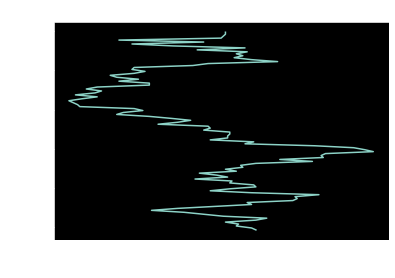

In [21]:
da.V[2,-2,:].plot(y='Depth', yincrease=False)


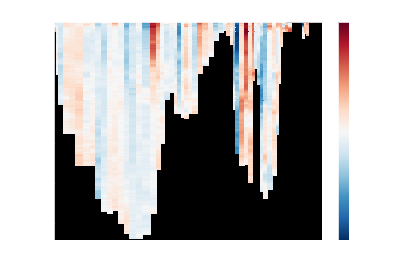

In [43]:
da.V.sel(year=2017).plot(y='depth', yincrease=False)

\
Plot evolution of Velocity profile at station E

In [ ]:
# Extra Refdist value associated with Station E
distSTA = da.Refdist.values[da.Staname.values=='E'][0]

# Plot 
da.V.sel(Refdist=distSTA,Year=slice('2004','2017')).plot(y='Depth', yincrease=False)

<br><br>
#### TODO: plot distribution of depth average velocity at a specific station and compute the associated ellipse
Have a look to:
1. J. Lilly notes on variance ellipse http://jmlilly.net/course/v3/VarianceEllipsesDemo.html
2. Confidence ellipse function https://matplotlib.org/3.2.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
3. How to draw patch using cartopy https://scitools.org.uk/cartopy/docs/v0.5/matplotlib/introductory_examples/02.polygon.html
